In [1]:
import os

### openBLAS will not work properly in jupyter notebook
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
from scipy import stats as ss
import snapatac2 as snap
import scanpy as sc
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Impor

In [2]:
snap.__version__

'2.7.0'

## Read RNA metadata

In [3]:
rmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', sep = '\t')
dna = np.unique(rmeta['dna'].dropna())
file_dna = [name + "_processed.h5ad" for name in dna]
print(file_dna)

['QY_2600_processed.h5ad', 'QY_2602_processed.h5ad', 'QY_2604_processed.h5ad', 'QY_2606_processed.h5ad', 'QY_2608_processed.h5ad', 'QY_2610_processed.h5ad', 'QY_2612_processed.h5ad', 'QY_2614_processed.h5ad', 'QY_2616_processed.h5ad', 'QY_2618_processed.h5ad', 'QY_2620_processed.h5ad', 'QY_2622_processed.h5ad', 'QY_2624_processed.h5ad', 'QY_2626_processed.h5ad', 'QY_2661_processed.h5ad', 'QY_2663_processed.h5ad']


In [7]:
### read in pre-processed DNA 
dmeta = []
for i, file in enumerate(file_dna):
    data = snap.read("snapatac/" + file)
    tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns) 
    dmeta.append(tmp_meta[['n_fragment','frac_dup','frac_mito','doublet_probability','doublet_score']])
    data.close()

/tmp/ipykernel_1619150/3163936700.py:5: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns)
/tmp/ipykernel_1619150/3163936700.py:5: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns)
/tmp/ipykernel_1619150/3163936700.py:5: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns)
/tmp/ipykernel_1619150/31639

In [10]:
rmeta = pd.read_csv('FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', sep = '\t')
cdmeta = pd.concat(dmeta, axis=0)

rmeta['atac_bc'] = rmeta['dna_bc']
rmeta['dna_bc'] = rmeta['dna'].astype(str) + ":" + rmeta['atac_bc'].astype(str)
cdmeta = cdmeta.merge(rmeta, right_on = 'dna_bc', left_index = True)
cdmeta.head()

print(rmeta.shape)
print(cdmeta.shape)

(131297, 28)
(131253, 33)


## Read in DNA data, split and clustering using snapATAC2

In [12]:
data = snap.AnnDataSet(
    adatas = [(name, "snapatac/" + adata) for name, adata in zip(dna, file_dna)],
    filename = "FNIH_Donor_pool.histone.h5ads"
)

### make sure barcode is unique
unique_cell_ids = [sa + ':' + bc for sa, bc in zip(data.obs['sample'], data.obs_names)]
data.obs_names = unique_cell_ids

Unable to create stacked arrays for these keys: fragment_paired
/tmp/ipykernel_1144683/2072313686.py:7: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  unique_cell_ids = [sa + ':' + bc for sa, bc in zip(data.obs['sample'], data.obs_names)]


In [13]:
### Convert to anndata in memory and subset singlet
data = data.to_adata()
tdata = data[np.intersect1d(data.obs.index, cdmeta['dna_bc']),:]

cdmeta.index = cdmeta['dna_bc']
tdata.obs = cdmeta.loc[tdata.obs_names]
tdata.obs = tdata.obs.astype(str)
tdata.write("FNIH_Donor_pool.histone.h5ad")

tdata

/tmp/ipykernel_1144683/1326490887.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  data = data.to_adata()
/tmp/ipykernel_1144683/1326490887.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  data = data.to_adata()
... storing 'n_fragment' as categorical
... storing 'frac_dup' as categorical
... storing 'frac_mito' as categorical
... storing 'doublet_probability' as categorical
... storing 'doublet_score_x' as categorical
... storing 'orig.ident' as categorical
... storing 'nCount_RNA' as categorical
... storing 'nFeature_RNA' as categorical
... storing 'percent.mt' as categorical
... storing 'percent.ribo' as categorical
... storing 'RNA_snn_res.0.3' as categorical
... storing 'seurat_clusters' as categorical
... storing 'doublet_score_y' as categorical


AnnData object with n_obs × n_vars = 131253 × 202081
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'RNA_snn_res.0.3', 'seurat_clusters', 'doublet_score_y', 'doublet_ident', 'DROPLET.TYPE', 'BEST.GUESS', 'NEXT.GUESS', 'rna', 'rna_bc', 'dna', 'library_info', 'dna_bc', 'Donor', 'Batch', 'Target', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'predicted.celltype', 'predicted.celltype_scores', 'predicted.cellsubtype', 'predicted.cellsubtype_scores', 'atac_bc'
    uns: 'AnnDataSet'

In [53]:
### calculate for heatmap
tdata.obs['condition'] = tdata.obs['predicted.celltype'].astype(str) + "_" + tdata.obs['Target'].astype(str)
rpm = snap.tl.aggregate_X(tdata, groupby = 'condition', normalize = "RPM")

drpm = pd.DataFrame(rpm.X, columns = rpm.var_names, index = rpm.obs_names)
drpm.T.to_csv('FNIH_Heart_pool.histone_RPM_by_condition.csv')

## Split into K27ac and K27me3

In [15]:
k27ac_data = tdata[tdata.obs["Target"] == "H3K27ac", :]
k27me3_data = tdata[tdata.obs["Target"] == "H3K27me3", :]

In [20]:
### retain only euchromsome genes
chrx = [ele for ele in k27ac_data.var_names if 'chrX' in ele]
keep_vars = ~k27ac_data.var_names.isin(chrx)
k27ac_data = k27ac_data[:, keep_vars]

tmp = k27ac_data
snap.pp.select_features(tmp, n_features = 100000,
                        blacklist = "/projects/ps-renlab/y2xie/projects/genome_ref/hg38_CnR_blacklist.bed")
snap.tl.spectral(tmp, weighted_by_sd = True, random_state = 921)
if len(tmp.obs_names) >= 500000:
    k = 50
elif (len(tmp.obs_names) >= 200000 & len(tmp.obs_names) < 500000):
    k = 25
else:
    k = 15

### Batch correction
snap.pp.harmony(tmp, batch = 'library_info')

print("performing leiden clustering...")
snap.pp.knn(tmp, n_neighbors = k, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.umap(tmp, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.leiden(tmp, resolution = 0.5, objective_function = 'RBConfiguration',
               use_leidenalg = True, weighted = True)
k27ac_data = tmp

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/snapatac2/preprocessing/_basic.py:976: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['count'] = count
2024-09-17 12:25:34 - INFO - Selected 99910 features.
2024-09-17 12:27:42,230 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:27:42 - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:27:46,524 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:27:46 - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:27:46,769 - harmonypy - INFO - Iteration 1 of 10
2024-09-17 12:27:46 - INFO - Iteration 1 of 10
2024-09-17 12:27:58,154 - harmonypy - INFO - Iteration 2 of 10
2024-09-17 12:27:58 - INFO - Iteration 2 of 10
2024-09-17 12:28:10,304 - harmonypy - INFO - Iteration 3 of 10
2024-09-17 12:28:10 - INFO - Iteration 3 of 10
2024-09-17 12:28:22,256 - harmonypy - INFO - Iteratio

performing leiden clustering...


/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [21]:
chrx = [ele for ele in k27me3_data.var_names if 'chrX' in ele]
keep_vars = ~k27me3_data.var_names.isin(chrx)
k27me3_data = k27me3_data[:, keep_vars]

tmp = k27me3_data
snap.pp.select_features(tmp, n_features = 100000,
                        blacklist = "/projects/ps-renlab/y2xie/projects/genome_ref/hg38_CnR_blacklist.bed")
snap.tl.spectral(tmp, weighted_by_sd = True, random_state = 921)
if len(tmp.obs_names) >= 500000:
    k = 50
elif (len(tmp.obs_names) >= 200000 & len(tmp.obs_names) < 500000):
    k = 25
else:
    k = 15

### Batch correction
snap.pp.harmony(tmp, batch = 'library_info')

print("performing leiden clustering...")
snap.pp.knn(tmp, n_neighbors = k, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.umap(tmp, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.leiden(tmp, resolution = 0.5, objective_function = 'RBConfiguration',
               use_leidenalg = True, weighted = True)
k27me3_data = tmp

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/snapatac2/preprocessing/_basic.py:976: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['count'] = count
2024-09-17 12:30:36 - INFO - Selected 99870 features.
2024-09-17 12:32:51,050 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:32:51 - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:32:54,996 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:32:54 - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:32:55,194 - harmonypy - INFO - Iteration 1 of 10
2024-09-17 12:32:55 - INFO - Iteration 1 of 10
2024-09-17 12:33:05,318 - harmonypy - INFO - Iteration 2 of 10
2024-09-17 12:33:05 - INFO - Iteration 2 of 10
2024-09-17 12:33:16,201 - harmonypy - INFO - Iteration 3 of 10
2024-09-17 12:33:16 - INFO - Iteration 3 of 10
2024-09-17 12:33:24,047 - harmonypy - INFO - Converge

performing leiden clustering...


/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


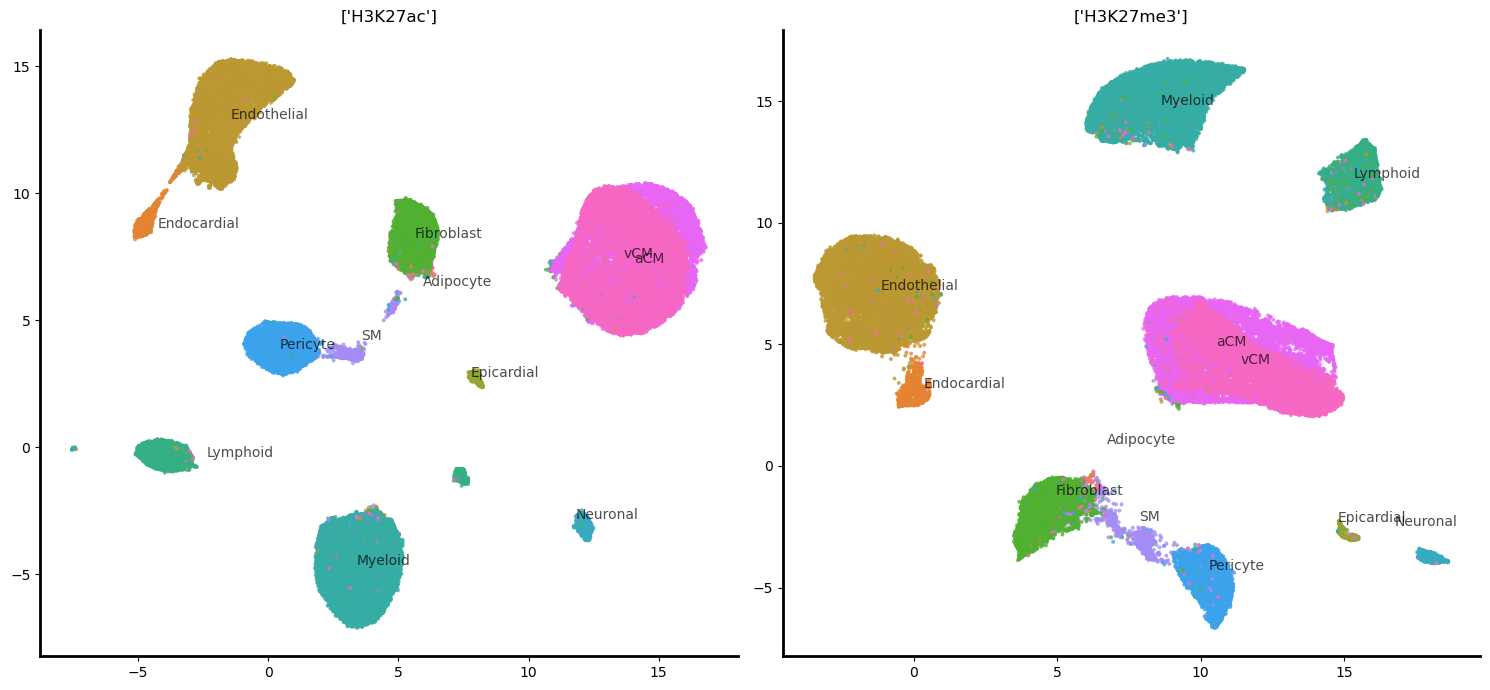

In [22]:
hhue = 'predicted.celltype'

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for i in range(len([k27ac_data, k27me3_data])):
    data = [k27ac_data, k27me3_data][i]
    ttarget = np.unique(data.obs['Target'])
    yi = data.obsm['X_umap']
    lmeta = data.obs

    ax = axes[i]
    sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=ax, s=8, alpha=0.8, # palette = celltype_colors,
                    linewidth=0, hue=lmeta[hhue], legend = False)
    ax.set_title(ttarget)
    sns.despine()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    
    ### manually label point
    representative_points = []
    for cluster in np.unique(lmeta[hhue]):
        cluster_indices = np.where(lmeta == cluster)[0]
        centroid = np.mean(yi[cluster_indices], axis=0)
        representative_points.append(centroid)

    for ii, label in enumerate(np.unique(lmeta[hhue])):
        ax.annotate(label, (representative_points[ii][0], representative_points[ii][1]), fontsize=10, alpha=0.7)


plt.tight_layout()

In [23]:
## save DNA objects
k27ac_data.obs = k27ac_data.obs.astype(str)
k27ac_data.write("FNIH_Heart_pool.H3K27ac.h5ad")
k27me3_data.obs = k27me3_data.obs.astype(str)
k27me3_data.write("FNIH_Heart_pool.H3K27me3.h5ad")

... storing 'n_fragment' as categorical
... storing 'frac_dup' as categorical
... storing 'frac_mito' as categorical
... storing 'doublet_probability' as categorical
... storing 'doublet_score_x' as categorical
... storing 'orig.ident' as categorical
... storing 'nCount_RNA' as categorical
... storing 'nFeature_RNA' as categorical
... storing 'percent.mt' as categorical
... storing 'percent.ribo' as categorical
... storing 'RNA_snn_res.0.3' as categorical
... storing 'seurat_clusters' as categorical
... storing 'doublet_score_y' as categorical
... storing 'doublet_ident' as categorical
... storing 'DROPLET.TYPE' as categorical
... storing 'BEST.GUESS' as categorical
... storing 'NEXT.GUESS' as categorical
... storing 'rna' as categorical
... storing 'rna_bc' as categorical
... storing 'dna' as categorical
... storing 'library_info' as categorical
... storing 'Donor' as categorical
... storing 'Batch' as categorical
... storing 'Target' as categorical
... storing 'nCount_SCT' as categor

In [5]:
k27ac_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27ac.h5ad", backed = None)
k27me3_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27me3.h5ad", backed = None)

dmeta = pd.concat([k27ac_data.obs, k27me3_data.obs], axis = 0)

In [24]:
### Also export umap cood to save
pd.DataFrame(k27ac_data.obsm['X_umap'], index=k27ac_data.obs_names).to_csv("FNIH_Heart_pool.H3K27ac.umap.csv")
pd.DataFrame(k27me3_data.obsm['X_umap'], index=k27me3_data.obs_names).to_csv("FNIH_Heart_pool.H3K27me3.umap.csv")